## Determining Optimal Zipcodes to live in - Data Science Capstone Project
### Introduction

Austin, Texas has quickly emerged as one of the fastest growing cities in America. Austin’s population continues to grow, with an anticipated growth rate of 3% year over year. This is not surprising, as people are drawn to the relatively low cost of living, tech-focused industry, outdoorsy lifestyle, and year-round activities that take place in the city. Often dubbed the Silicon Valley of Texas, Austin continues to attract tech giants such as Apple, Google, Indeed and IBM - as well as many startup companies - leading to a robust job market. That combined with the attractive lifestyle that Austin presents has brought thousands of new people to the city and surrounding areas, which has had a massive effect on the real estate market. Though it continues to see positive change throughout the years, the market can be quite intimidating when it comes to deciding the right part of the city to move to, especially for those unfamiliar to the area. Whether one is looking to rent or a buy, it can be both competitive and time-consuming to find the ideal home. 

With this in mind, our goal is to help make this decision easier by determining optimal zip codes for people to consider when finding a new home in the Austin area. In order to achieve this, we will be utilizing Foursquare's API in order to make calls that will give us locational data on restaurants, gyms, parks, and any relevant venues in the surrounding area that could assist or hinder characteristics within the zipcode.

### Data Preparation and Feature Selection

Data for this project was collected from [AustinTexas.gov](http://www.austintexas.gov/page/demographic-data) under the American Community Survey 2017 Profiles for ZIP Codes section. Each zipcode was a HTML download link containing an excel file holding four sheets of data. Each of the four sheets of data were categories containing data related to Demographic, Economic, Social, and Housing characteristics. Data that was labeled as necessary to include was subjective, but important features considered originated primarily from a set of survey responses to features deemed "Important" when considering a place to live. Because of this, not all quantifiable categories were included, and categories projected to explain a small amount of variance in potential machine learning models like race were excluded.

### Data Cleaning

All four sheets were scraped for desired data using a small program that iterates through each of the four sheets. In our excel files, our desirable features were under one column, while data related to those features were within adjacent cells. In order to fix this, the program written had to use the Series.isin() function in order to retrieve the names of the features, and their data. This program was reused for all 46 zipcodes, and for the purpose of this project, only one call of the program will be shown to save the reader time. Once each sheet had been scraped for important features I stored them along with the respective zipcode into a single dataframe to call on later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
import geocoder
import seaborn as sns
import json

In [2]:
relevant_cols = ['Male', 'Female', 'Median age in years', 'Mean household income', 
                'Family households', 'Nonfamily households', 'Occupied housing units', 
                 'Vacant housing units', 'Average home value', 'Average gross rent']

relevant_cols

['Male',
 'Female',
 'Median age in years',
 'Mean household income',
 'Family households',
 'Nonfamily households',
 'Occupied housing units',
 'Vacant housing units',
 'Average home value',
 'Average gross rent']

In [3]:
def cleanTable(df1, df2, df3, df4, zipcode):
    
    """This program aims to take 4 excel files and a zipcode labeled in the dataframe as inputs, one for each of the sheets within
    an individal zipcode excel file, and organize it into a row within a dataframe."""
    
    #Re-label our column names so the code below is reusable
    df1.columns = ['ACS_Profile_Report', 'Number', 'MOE', 'Pct']
    df2.columns = ['ACS_Profile_Report', 'Number', 'MOE', 'Pct']
    df3.columns = ['ACS_Profile_Report', 'Number', 'MOE', 'Pct']
    df4.columns = ['ACS_Profile_Report', 'Number', 'MOE', 'Pct']
    
    #strip all leading and trailing spaces within the column listed so no data is skipped when iterating
    df1['ACS_Profile_Report'] = df1['ACS_Profile_Report'].str.strip()
    df2['ACS_Profile_Report'] = df2['ACS_Profile_Report'].str.strip()
    df3['ACS_Profile_Report'] = df3['ACS_Profile_Report'].str.strip()
    df4['ACS_Profile_Report'] = df4['ACS_Profile_Report'].str.strip()
    
    #For each dataframe - if the Profile Report column contains the category name we want as an independant column, retrieve it.
    for data in df1['ACS_Profile_Report']:
        if data in relevant_cols:
            df1 = df1.loc[df1['ACS_Profile_Report'].isin(relevant_cols)]
        else:
            continue
    
    for data in df2['ACS_Profile_Report']:
        if data in relevant_cols:
            df2 = df2.loc[df2['ACS_Profile_Report'].isin(relevant_cols)]
        else:
            continue
            
    for data in df3['ACS_Profile_Report']:
        if data in relevant_cols:
            df3 = df3.loc[df3['ACS_Profile_Report'].isin(relevant_cols)]
        else:
            continue
            
    for data in df4['ACS_Profile_Report']:
        if data in relevant_cols:
            df4 = df4.loc[df4['ACS_Profile_Report'].isin(relevant_cols)]
        else:
            continue
            
    new_df = pd.concat([df1,df2,df3,df4])
    new_df['Zipcode'] = zipcode
    new_df.drop_duplicates(inplace=True)
    new_df.drop(columns=['MOE', 'Pct'], inplace=True)
    new_df['Number'] = new_df['Number'].astype('int64')
    new_df = pd.pivot_table(new_df, columns='ACS_Profile_Report', values='Number', index='Zipcode')
    new_df.reset_index()
    
    return new_df

__Importing four excel files, one for each sheet within the excel file, all related to a single zipcode.__

In [4]:
df_two = pd.read_excel('ACS_Profile_78701_v2.xls', sheet_name='Economic')
df_one = pd.read_excel('ACS_Profile_78701_v2.xls', sheet_name='Demographic')
df_three = pd.read_excel('ACS_Profile_78701_v2.xls', sheet_name='Social')
df_four = pd.read_excel('ACS_Profile_78701_v2.xls', sheet_name='Housing')

__Example of what the individual rows look like in their respective columns after being added into the dataframe__

In [5]:
df_78701 = cleanTable(df_one, df_two, df_three, df_four, 78701)
df_78701

ACS_Profile_Report,Average gross rent,Average home value,Family households,Female,Male,Mean household income,Median age in years,Nonfamily households,Occupied housing units,Vacant housing units
Zipcode,,,,,,,,,,
78701,1917,728781,1187,3208,4667,173289,35,3668,4855,1721


__Once all dataframes were concatenated together, dataframe was cleaned up and stored as a csv file under the name Austin_Zipcodes__

In [6]:
df = pd.read_csv('Austin_Zipcodes.csv')
df.head()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,4855,1721
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,8937,902
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,9723,1324
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,23213,2602
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,8370,1966


__Instantiate our Nominatim object to retrieve geographic coordinates for our zipcodes with Austin.__

In [7]:
geolocator = Nominatim(user_agent='austincityscrape')

In [8]:
lat = []
lng = []
for i in df['Zipcode']:
    
    location = geolocator.geocode(i)
    latitude = location.latitude
    lat.append(latitude)
    longitude = location.longitude
    lng.append(longitude)

df['Latitude'] = lat
df['Longitude'] = lng
df.head(10)

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units,Latitude,Longitude
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,4855,1721,30.280466,-97.750088
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,8937,902,30.278460,-97.718800
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,9723,1324,30.271561,-97.761267
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,23213,2602,30.227821,-97.778097
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,8370,1966,30.286748,-97.725799
5,78721,1059,215338,52873,34,2458,1739,12447,5885,6562,4197,435,30.272626,-97.684817
6,78722,1355,380270,95443,32,1293,1818,7254,3266,3988,3111,304,30.285703,-97.718354
7,78723,1071,299158,71897,33,6690,5828,33170,16301,16869,12518,1259,30.252530,-97.681176
8,78724,1116,138684,55252,28,5071,1289,24833,12578,12255,6360,394,30.290684,-97.626557
9,78725,1347,139626,66225,35,1709,835,7517,4044,3473,2544,54,30.231742,-97.643690


In [9]:
austin = geolocator.geocode('Austin, TX')
austin_lat = austin.latitude
austin_lng = austin.longitude

print('The coordinates of Austinn are {}, {}.'.format(austin_lat, austin_lng))

The coordinates of Austinn are 30.2711286, -97.7436995.


### Methodology - Exploratory Data Analysis

There are lots of factors potentially explaining the variance seen between home values within zipcodes, making it hard to accurately develop models predicting the price. Of these factors, things that were gathered (previously shown in the data preparation step) included average gross rent, average home value, mean household income, median age in years, occupied housing units, and so on. Once this data was gathered, preliminary information was gathered using the describe function, in order to determine minimum and maxiumum values for a lot of these key features listed.

For further analysis, an inital look of the distribution of zipcodes throughout Austin using the Folium Library will be created, allowing us to see if we can initally hypothesize which zipcodes will cluster together. From there, the next steps involve the creation of a couple new features. The first primary feature, _Percent Occupied_, will allow for us to see the percent of homes/apartments already occupied within the zipcode, to determine saturation. The second feature, _Competition_, will be created as a result of bucketing the zipcode's by percentage occupied - either being listed as high, medium, or low competition relative to one another.

Additionally, we will use these features to analyze which zipcodes have the highest/lowest percent occupancy, as well as whether or not we can find any correlation between features, and with competition. Once this is discovered, we will use K-means clustering in order to cluster these neighborhoods together to determine commonality between one another, and figure out what neighborhood would be best for an individual trying to find a place to rent, as well as a couple starting a family in the city.

Finally, we will use Multiple Linear Regression as a secondary algorithm to determine how well we can predict the average home value of a neighborhood given a set of independent variables. Coupled with the clusters of neighborhoods using our K-means algorithm, this should give us sufficient information to give to the user, in order to assist with determining the most suitable zipcode.

In [10]:
df.describe()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units,Latitude,Longitude
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,78726.847826,1361.086957,367466.717391,104178.391304,34.869565,5844.152174,4571.847826,27240.630435,13772.826087,13467.804348,10416.000000,875.413043,31.095254,-93.426483
std,33.308636,286.508392,210768.771022,47021.990273,5.079846,3824.912031,3732.012343,17230.327910,8822.314587,8460.238270,6698.615001,622.724251,3.773536,20.538917
min,78610.000000,973.000000,85032.000000,41357.000000,21.000000,110.000000,108.000000,517.000000,280.000000,237.000000,218.000000,34.000000,30.144664,-97.942873
25%,78723.250000,1137.500000,212339.500000,70304.250000,32.000000,3577.250000,1709.750000,15779.250000,7841.500000,7904.250000,5757.750000,403.250000,30.234195,-97.796542
50%,78734.500000,1304.500000,301192.000000,89451.500000,34.000000,4992.500000,3739.000000,23367.000000,11681.000000,11686.000000,8189.500000,766.000000,30.300040,-97.748777
75%,78747.750000,1438.250000,473516.000000,138648.000000,38.750000,7789.750000,5930.750000,33146.250000,16284.500000,17074.500000,12858.250000,1223.000000,30.373348,-97.694594
max,78759.000000,2409.000000,962063.000000,217305.000000,46.000000,21110.000000,15351.000000,85450.000000,41644.000000,43806.000000,28469.000000,2622.000000,48.696388,1.858556


In [11]:
# Map of Austin
map_austin = folium.Map(location=[austin_lat, austin_lng], tiles='Stamen Terrain', zoom_start=10)
coordinates = df[['Latitude', 'Longitude']]
coordinates_list = coordinates.values.tolist()

# Map Markers
for point in range(0, len(coordinates_list)):
    folium.CircleMarker(
        coordinates_list[point],
        radius=5,
        popup=str(df['Zipcode'][point]),
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

__Creating new column indicating the percent of homes occupied within the given zipcode__

In [12]:
df['Percent Occupied'] = round(df['Occupied housing units']/(df['Occupied housing units'] + df['Vacant housing units'])*100, 2)
df.head()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units,Latitude,Longitude,Percent Occupied
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,4855,1721,30.280466,-97.750088,73.83
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,8937,902,30.278460,-97.718800,90.83
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,9723,1324,30.271561,-97.761267,88.01
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,23213,2602,30.227821,-97.778097,89.92
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,8370,1966,30.286748,-97.725799,80.98


#### Looks like zipcode 78746 has the highest average home value, while zipcode 78742 has the lowest.

Looking back at the map we can easily see that 78746 is located in a predominantly more expensive section of neighborhoods overlooking the most popular lake in Austin - not so surprising, considering that it is also relatively close to Downtown.

Text(0.5, 1.0, 'Average Home Value for each Zipcode')

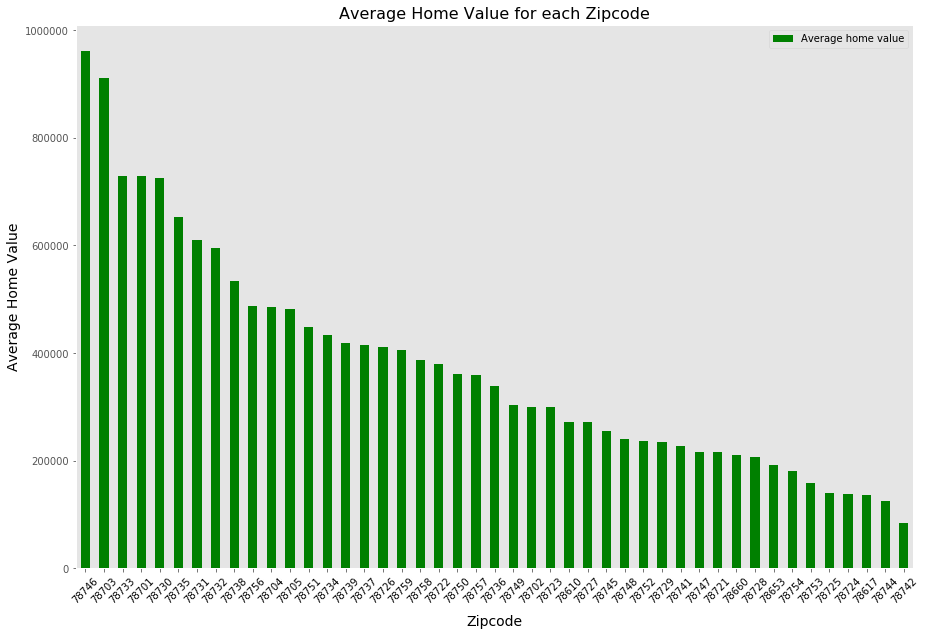

In [13]:
from matplotlib import cm
import matplotlib as mpl
mpl.style.use('ggplot')

fig,ax = plt.subplots(figsize=(15,10))

home_df = df.groupby('Zipcode')['Average home value'].sum().reset_index().sort_values('Average home value', ascending=False)
home_df.plot(kind='bar', x='Zipcode', y='Average home value', color='green', ax=ax)

xlabel = [i for i in home_df['Zipcode']]
ax.grid(False)
ax.set_xlabel('Zipcode', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Average Home Value', color='black', fontsize=14)
ax.set_xticklabels(xlabel, color='black', rotation=45)
ax.set_title('Average Home Value for each Zipcode', fontsize=16)

#### Visualization of the homes occupied by zipcode.

Something surprising is showing - Zipcode 78701, located near the heart of Downtown Austin and very close to college campus, has the lowest percentage of homes occupied. This is noteworthy, as the average price of homes is only going up in this part of Texas, and families with disposable incomes could purchase in this location with the goal of renting it out to college students for a profit.

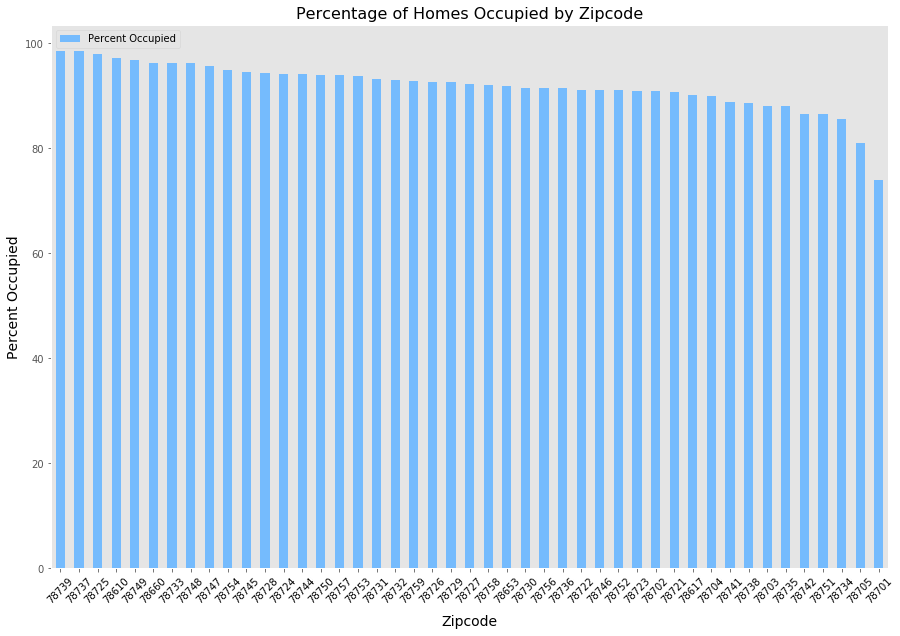

In [14]:
fig,ax = plt.subplots(figsize=(15,10))

occ_df = df.groupby('Zipcode')['Percent Occupied'].mean().reset_index().sort_values('Percent Occupied', ascending=False)
occ_df.plot(kind='bar', x='Zipcode', y='Percent Occupied', color='xkcd:sky blue', ax=ax)

xlabel = [i for i in occ_df['Zipcode']]
ax.grid(False)
ax.set_xlabel('Zipcode', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Percent Occupied', color='black', fontsize=14)
ax.set_xticklabels(xlabel, color='black', rotation=45)
ax.set_title('Percentage of Homes Occupied by Zipcode', fontsize=16)
ax.legend(loc='upper left')

In [15]:
competition = []
for i in df['Percent Occupied']:
    if i >= 90.00:
        competition.append('High')
    elif i <= 89.99 and i >= 85.01:
        competition.append('Medium')
    else:
        competition.append('Low')
        
df['Competition'] = competition

#### Looks like there is an inverse correlation between home-buying competition and average home value in Austin.

Knowing this (which of course is obvious to most), it might be better to look for homes within the Medium competition range, specifically ones within the 300-400k range.

Text(0.5, 1.0, 'Home value distribution vs zipcode competition')

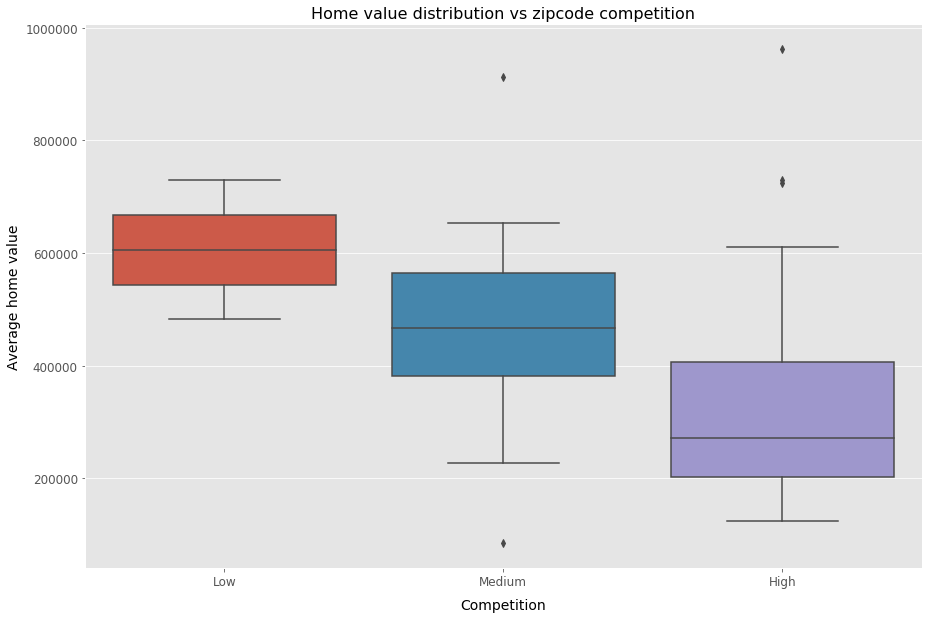

In [16]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='Competition', y='Average home value', data=df, order=['Low', 'Medium', 'High'])

ax.set_xlabel('Competition', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Average home value', color='black', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title('Home value distribution vs zipcode competition', fontsize=16)

In [17]:
df.head()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units,Latitude,Longitude,Percent Occupied,Competition
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,4855,1721,30.280466,-97.750088,73.83,Low
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,8937,902,30.278460,-97.718800,90.83,High
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,9723,1324,30.271561,-97.761267,88.01,Medium
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,23213,2602,30.227821,-97.778097,89.92,Medium
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,8370,1966,30.286748,-97.725799,80.98,Low


__Looks like median age in years is correlated with the average household income up until your 40s, where it is less clear__

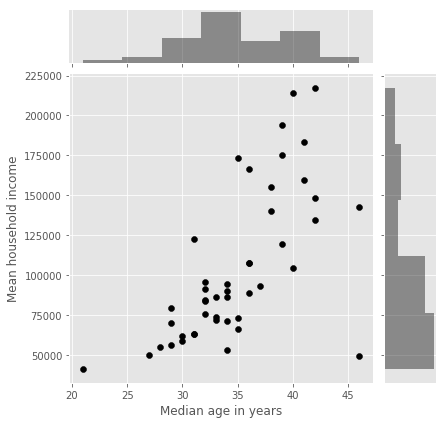

In [18]:
sns.jointplot(x='Median age in years', y='Mean household income', data=df, color='black')

In [19]:
df.describe()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,Occupied housing units,Vacant housing units,Latitude,Longitude,Percent Occupied
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,78726.847826,1361.086957,367466.717391,104178.391304,34.869565,5844.152174,4571.847826,27240.630435,13772.826087,13467.804348,10416.000000,875.413043,31.095254,-93.426483,91.857174
std,33.308636,286.508392,210768.771022,47021.990273,5.079846,3824.912031,3732.012343,17230.327910,8822.314587,8460.238270,6698.615001,622.724251,3.773536,20.538917,4.475047
min,78610.000000,973.000000,85032.000000,41357.000000,21.000000,110.000000,108.000000,517.000000,280.000000,237.000000,218.000000,34.000000,30.144664,-97.942873,73.830000
25%,78723.250000,1137.500000,212339.500000,70304.250000,32.000000,3577.250000,1709.750000,15779.250000,7841.500000,7904.250000,5757.750000,403.250000,30.234195,-97.796542,90.665000
50%,78734.500000,1304.500000,301192.000000,89451.500000,34.000000,4992.500000,3739.000000,23367.000000,11681.000000,11686.000000,8189.500000,766.000000,30.300040,-97.748777,92.155000
75%,78747.750000,1438.250000,473516.000000,138648.000000,38.750000,7789.750000,5930.750000,33146.250000,16284.500000,17074.500000,12858.250000,1223.000000,30.373348,-97.694594,94.327500
max,78759.000000,2409.000000,962063.000000,217305.000000,46.000000,21110.000000,15351.000000,85450.000000,41644.000000,43806.000000,28469.000000,2622.000000,48.696388,1.858556,98.560000


## Pulling venues from Foursquare for analysis

Credentials were removed for obvious reasons.

In [20]:
VERSION = '20180605'

print('Credentials Entered.')

Credentials Entered.


#### Importing necessary libraries to further explore data

In [21]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [22]:
radius = 1500
LIMIT = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, austin_lat, austin_lng, VERSION, radius, LIMIT)

results = requests.get(url).json()

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
venues = results['response']['groups'][0]['items']      #grabs the items key from the groups dictionary to pull venues
    
nearby_venues = json_normalize(venues)      #Flattens the JSON file


filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]


nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]     #pulling the column names after the period


print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

100 venues were returned by Foursquare.


,name,categories,lat,lng
0,Perry's Steakhouse,Steakhouse,30.269374,-97.743676
1,Paramount Theatre,Movie Theater,30.269457,-97.742077
2,Chi'lantro BBQ,Food Truck,30.270510,-97.741949
3,Caroline Restaurant,Hotel,30.268816,-97.742298
4,The Contemporary Austin: Jones Center,Art Museum,30.269116,-97.742466


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
austin_venues = getNearbyVenues(names=df['Zipcode'], latitudes=df['Latitude'], longitudes=df['Longitude'])

In [27]:
austin_venues.head()

,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,78701,30.280466,-97.750088,Pease District Park,30.283418,-97.753301,Park
1,78701,30.280466,-97.750088,Castle Hill Fitness,30.276626,-97.752003,Gym
2,78701,30.280466,-97.750088,Austin Land & Cattle,30.277549,-97.750821,Steakhouse
3,78701,30.280466,-97.750088,Hotel Ella,30.283102,-97.745465,Hotel
4,78701,30.280466,-97.750088,HOPE Outdoor Gallery,30.276095,-97.752966,Art Gallery


In [28]:
austin_venues.groupby('Zipcode').count()

,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zipcode,,,,,,
78610,5,5,5,5,5,5
78617,5,5,5,5,5,5
78653,2,2,2,2,2,2
78701,100,100,100,100,100,100
78702,100,100,100,100,100,100
78703,100,100,100,100,100,100
78704,62,62,62,62,62,62
78705,83,83,83,83,83,83
78721,26,26,26,26,26,26


In [29]:
print('There are {} uniques categories.'.format(len(austin_venues['Venue Category'].unique())))

There are 270 uniques categories.


One hot encoding in order to get columns for each of the categories pulled from the Foursquare API

In [30]:
# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
austin_onehot['Zipcode'] = austin_venues['Zipcode']

# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

austin_onehot.head()

,Zipcode,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,78701,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78701,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
austin_grouped = austin_onehot.groupby('Zipcode').mean().reset_index()
austin_grouped.head()

,Zipcode,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,78610,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
1,78617,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
2,78653,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
3,78701,0.0,0.00,0.0,0.06,0.0,0.01,0.01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.01,0.01,0.04
4,78702,0.0,0.01,0.0,0.03,0.0,0.01,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.02


Getting a frequency count of the most common venues by zipcode.

In [32]:
num_top_venues = 5

for ven in austin_grouped['Zipcode']:
    print(ven)
    temp = austin_grouped[austin_grouped['Zipcode'] == ven].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

78610
           venue  freq
0         Bistro   0.2
1    Supermarket   0.2
2  Train Station   0.2
3           Park   0.2
4     Restaurant   0.2


78617
               venue  freq
0          Gun Range   0.2
1         Nail Salon   0.2
2  Convenience Store   0.2
3               Lake   0.2
4               Park   0.2


78653
                        venue  freq
0                 Dry Cleaner   0.5
1  Construction & Landscaping   0.5
2           Accessories Store   0.0
3                  Nail Salon   0.0
4                      Office   0.0


78701
                 venue  freq
0  American Restaurant  0.06
1                Hotel  0.04
2        Grocery Store  0.04
3            Pet Store  0.04
4          Yoga Studio  0.04


78702
               venue  freq
0        Coffee Shop  0.06
1                Bar  0.05
2  Convenience Store  0.05
3               Park  0.05
4         Food Truck  0.04


78703
                 venue  freq
0  American Restaurant  0.07
1   Mexican Restaurant  0.05
2          Yoga

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = austin_grouped['Zipcode']

for ind in np.arange(austin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78610,Supermarket,Restaurant,Bistro,Park,Train Station,Falafel Restaurant,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor
1,78617,Convenience Store,Park,Nail Salon,Gun Range,Lake,Cycle Studio,Dance Studio,Flower Shop,Flea Market,Fireworks Store
2,78653,Construction & Landscaping,Dry Cleaner,Yoga Studio,Farm,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Fast Food Restaurant
3,78701,American Restaurant,Yoga Studio,Grocery Store,Hotel,Pet Store,Bakery,Diner,Mexican Restaurant,Park,Sandwich Place
4,78702,Coffee Shop,Park,Bar,Convenience Store,Food Truck,Theater,Sandwich Place,Taco Place,Café,American Restaurant


Running K-means algorithm

In [35]:
from sklearn.cluster import KMeans
kclusters = 5
austin_grouped_clustering = austin_grouped.drop('Zipcode', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)
kmeans.labels_[0:36]

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = df
austin_merged = austin_merged.join(neighborhoods_venues_sorted.set_index('Zipcode'), on='Zipcode')
austin_merged.dropna(axis=0, inplace=True)
austin_merged['Cluster Labels'] = austin_merged['Cluster Labels'].astype(int)
austin_merged['Zipcode'] = austin_merged['Zipcode'].astype(str)
austin_merged.head()

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,...,American Restaurant,Yoga Studio,Grocery Store,Hotel,Pet Store,Bakery,Diner,Mexican Restaurant,Park,Sandwich Place
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,...,Coffee Shop,Park,Bar,Convenience Store,Food Truck,Theater,Sandwich Place,Taco Place,Café,American Restaurant
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,...,American Restaurant,Mexican Restaurant,Yoga Studio,Diner,Gym / Fitness Center,Grocery Store,Park,Clothing Store,Gym,Trail
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,...,Coffee Shop,Video Store,Food Truck,Mexican Restaurant,Taco Place,Convenience Store,Burger Joint,Bar,Thrift / Vintage Store,Rental Car Location
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,...,Sandwich Place,Mexican Restaurant,Park,Bar,History Museum,Coffee Shop,Food Truck,Art Museum,Fast Food Restaurant,Pool


In [37]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[austin_lat, austin_lng], zoom_start=10,tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'], austin_merged['Longitude'], austin_merged['Zipcode'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

_Couple of major points to note for people trying to move into a home:_

+ Cluster 0 seems to have venues specifically associated with Lady Bird Lake, and have a higher income and age on average 
+ Cluster 1 seems to consist primarily of restaurants, gyms, and parks.
+ Cluster 2 seems to involve maintenence and electronics venues
+ Cluster 3 seems to involve very similar venues relative to cluster 2.
+ Cluster 4 seems to involve restaurants and general clothing stores.

In [38]:
austin_merged.loc[austin_merged['Cluster Labels']==0]

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,78746,1618,962063,217305,42,7517,3331,28268,13882,14386,...,Lake,Harbor / Marina,Beach,Boat or Ferry,Yoga Studio,Farm,Event Service,Event Space,Eye Doctor,Falafel Restaurant


In [39]:
cluster_1 = austin_merged.loc[austin_merged['Cluster Labels']==1]
cluster_1.head(12)

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78701,1917,728781,173289,35,1187,3668,7875,4667,3208,...,American Restaurant,Yoga Studio,Grocery Store,Hotel,Pet Store,Bakery,Diner,Mexican Restaurant,Park,Sandwich Place
1,78702,1105,299188,73919,33,4180,4757,22876,11643,11233,...,Coffee Shop,Park,Bar,Convenience Store,Food Truck,Theater,Sandwich Place,Taco Place,Café,American Restaurant
2,78703,1542,911518,166396,36,4597,5126,20788,10429,10359,...,American Restaurant,Mexican Restaurant,Yoga Studio,Diner,Gym / Fitness Center,Grocery Store,Park,Clothing Store,Gym,Trail
3,78704,1309,486017,91223,32,7862,15351,47158,24489,22669,...,Coffee Shop,Video Store,Food Truck,Mexican Restaurant,Taco Place,Convenience Store,Burger Joint,Bar,Thrift / Vintage Store,Rental Car Location
4,78705,1397,482162,41357,21,1201,7169,33075,15932,17143,...,Sandwich Place,Mexican Restaurant,Park,Bar,History Museum,Coffee Shop,Food Truck,Art Museum,Fast Food Restaurant,Pool
5,78721,1059,215338,52873,34,2458,1739,12447,5885,6562,...,Liquor Store,Park,Shipping Store,Cajun / Creole Restaurant,Clothing Store,Recreation Center,Gas Station,Shoe Store,Market,Food & Drink Shop
6,78722,1355,380270,95443,32,1293,1818,7254,3266,3988,...,Coffee Shop,Bar,Café,Sandwich Place,American Restaurant,Park,Mexican Restaurant,Cocktail Bar,Taco Place,Fast Food Restaurant
7,78723,1071,299158,71897,33,6690,5828,33170,16301,16869,...,Art Gallery,Gas Station,Mexican Restaurant,Park,Burger Joint,Gym,Rental Service,Thrift / Vintage Store,Martial Arts Dojo,Music Venue
8,78724,1116,138684,55252,28,5071,1289,24833,12578,12255,...,General Entertainment,Gas Station,Athletics & Sports,Nightclub,Lawyer,Bar,Grocery Store,Market,Mobile Phone Shop,Movie Theater
10,78726,1200,411570,122559,31,3491,2063,14610,7251,7359,...,Gym,Gift Shop,Trail,Mexican Restaurant,Mattress Store,Movie Theater,Liquor Store,Gastropub,Donut Shop,Burger Joint


In [40]:
austin_merged.loc[austin_merged['Cluster Labels']==2]

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,78653,1261,191278,75678,32,4632,1700,20822,10350,10472,...,Construction & Landscaping,Dry Cleaner,Yoga Studio,Farm,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Fast Food Restaurant


In [41]:
austin_merged.loc[austin_merged['Cluster Labels']==3]

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,78737,1923,415172,148042,42,4543,762,15879,8023,7856,...,Home Service,Historic Site,Farmers Market,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Fast Food Restaurant


In [42]:
austin_merged.loc[austin_merged['Cluster Labels']==4]

,Zipcode,Average gross rent,Average home value,Mean household income,Median age in years,Family households,Nonfamily households,Total Population,Male,Female,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,78725,1347,139626,66225,35,1709,835,7517,4044,3473,...,Business Service,Farm,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Convention Center


Text(0.5, 1.0, 'Average of median age by Clustered Zipcode')

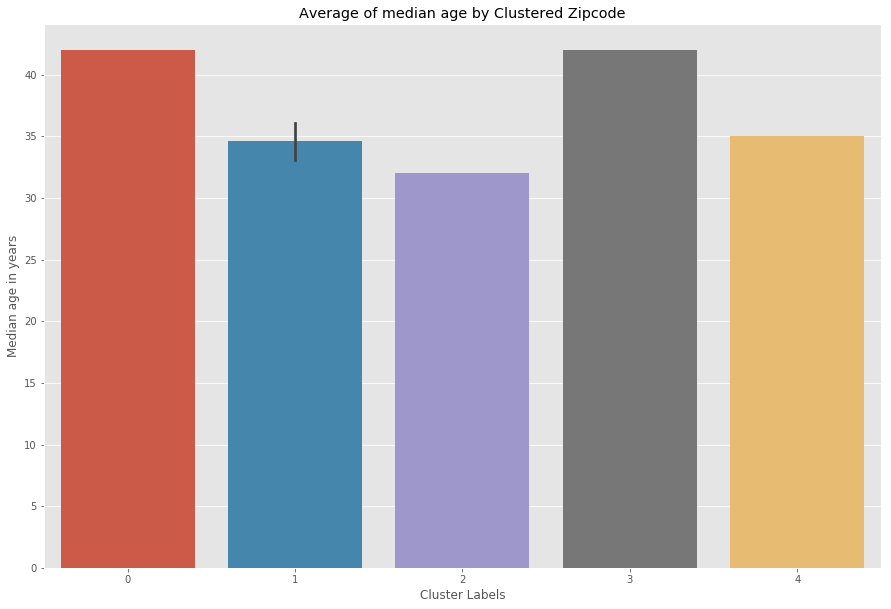

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='Cluster Labels', y='Median age in years', data=austin_merged, ax=ax)
ax.set_title('Average of median age by Clustered Zipcode')

Text(0.5, 1.0, 'Average rent by Clustered Zipcode')

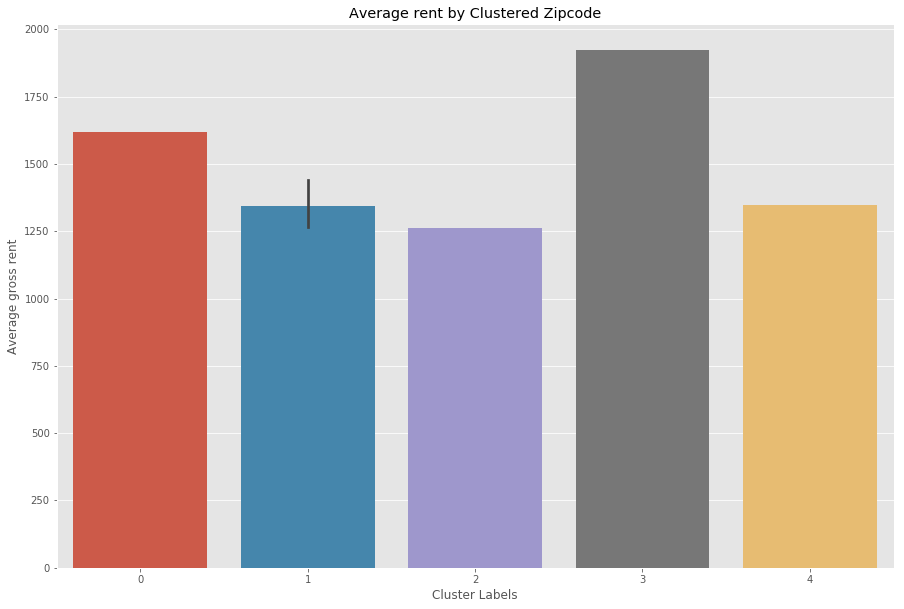

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='Cluster Labels', y='Average gross rent', data=austin_merged, ax=ax)
ax.set_title('Average rent by Clustered Zipcode')

Second machine learning algorithm, in order to predict the average home value for each zipcode.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lm = LinearRegression()

In [46]:
X = df[['Average gross rent', 'Mean household income', 'Median age in years']]
y = df['Average home value']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [48]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [49]:
lm.predict(X_test)

array([306703.05981301, 335730.04240325, 352978.66744022, 231310.81531756,
       269425.51245663, 750325.93387286, 290150.7526912 , 312372.62995056,
       743955.07967682, 429622.57923698])

74.5% accuracy for our multiple linear regression algorithm - indicating that the independent variables used are strong indicators for the value of a home within that zipcode.

In [50]:
lm.score(X_test, y_test)

0.7452607263626122

Coefficients for each variable used - Average gross rent, Mean household income, and median age in years respectively.

In [51]:
lm.coef_

array([-2.04920742e+02,  5.93791683e+00, -1.42207397e+04])

Y-intercept

In [52]:
lm.intercept_

526222.4668096607

In [53]:
print('Multiple Linear Regression equation: Average house value =', round(lm.intercept_, 2), '-', round(-1*lm.coef_[0],2), 'X1',
     '+', round(lm.coef_[1],2), 'X2', '-', round(-1*lm.coef_[2],2), 'X3')

Multiple Linear Regression equation: Average house value = 526222.47 - 204.92 X1 + 5.94 X2 - 14220.74 X3


## Results and Discussion

Our first set of analyses indicate that our average home value is about 367k - something very important for our home buying community. Follow-ups show that after we created a function to determine how competitive each zipcode was, we saw a negative correlation between competitiveness to buy a home and the average home value. Summed up in one sentence, it basically means that the higher the average home value, the less competition there is to buy that house. This seems obvious to most, but where to look and predicting whether or not the new homes in that area will have a value within your price range is not so obvious.

As expected, clustering didn't perform as well as intended, likely due to there being a low amount of venues near our zipcodes of interest in the Austin area. Although this is the case, there were a couple of distinguishing clusters that allowed for us to develop some insights about that area. Cluster 0 seems to be the most noticable, as it is apart of Westlake Hills, what seems to be the most expensive area to live in, containing many venues related to the surrounding lakeside area. Cluster 1 seems to be the more predominant group of zipcodes, as they all seem to contain a variety of restaurants, gyms, and parks. Aside from these two, there are not as many venues that really distinguish the other three from one another, which is a big reservation about the clustering algorithm in general. The less venues available to call from our Foursquare API (even within a 1500m distance!) the less accurate it will be. Barplots afterwards seem to really help distinguish differences seen in our clusters, as it shows that cluster 3 seems to have the most expensive rent on average as well as the highest median age on average. This would make sense, as our Jointplot earlier showed a noticeable correlation between age and average home value. If the average home value is higher on average, than our average rent will probably be higher on average as well.

After taking a look at the differences seen in our clustering, I wanted to further look into predicting the average home value for each of the zipcodes being tested. The most appropriate numerical categories were the catregories used in determining our independent variables. Once we imported our necessary libraries, we instantiated our LinearRegression object, split our model to train on 80% of the zipcodes, and then tested it for accuracy. At the end, our three independent variables were able to explain about 75% of the variance seen in the data.

Final equation for our MLR model: Average home value = $\$ 526,222.47 - $\$204.92X<sub>1</sub> + 5.94X<sub>2</sub> - $14,220.74X<sub>3

## Conclusions

This project was intended to serve as a tool to help narrow down the options behind choosing where to buy or rent a home. As previously shown, there were some very interesting insights seen, such as the low competitiveness seen in zipcode 78701 despite the close proximity to university and downtown. If interested, one could buy property in that area and rent it out to students for a long-term profit, and then sell the property 5 years down the line for its original value plus interest. Not only that, but we developed an equation that could help you calculate the average home value of an area code. 

A couple of minor changes to help increase the models accuracy would be to run an OLS (ordinary least squares) test on different combinations of independent variables to see which combination explains the most variance in the data, to improve overall accuracy. In addition, if it were possible - spend a little more time researching more efficient ways to determine all the varying categories capable of being pulled from the Foursquare API. Sometimes the same code produced more venues, sometimes a smaller amount, and sometimes it would timeout for an entire afternoon depending on the day, which made acquiring data unreliable.

Finally, finding out data on the different clusters produced helped give insights into what types of neighborhoods there are in the city of Austin. With this in mind, the people interesting in home buying or renting could take this data and look further into what are the most common venues/amenities in that surrounding area, to see if it most suits there desires.